# Predicting Cognitive Ability From Demographic Data

Authors: Anmin Yang & Shan Gao


todo

preamble:
- motivation


In [1]:
import numpy as np
import pandas as pd 
import os 

import matplotlib.pyplot as plt 
import seaborn as sns 

## Part 1: Data Overview and Preprocessing (Shan Gao & Anmin Yang)

### 1.1 Data Overview

todo

- choice of battery


In [2]:
# load data 
df = pd.read_csv('./data/battery50_df.csv')

# get shape
print(df.shape)

# get feature names 
print(df.columns)

(2302948, 11)
Index(['user_id', 'age', 'gender', 'education_level', 'country', 'test_run_id',
       'battery_id', 'specific_subtest_id', 'raw_score', 'time_of_day',
       'grand_index'],
      dtype='object')


In this dataset, both demograhic data and scores of web-based cognitive tests are available.</br>
Each battery consists of several subtests.<br>
The measurement of a participant's cognitive alility is based on the aggregated score of all the subtests within a battery.<br>

- **Features Used for Prediction**
    - **Deomographics**
        - Numerical Feature
            - age
        - Categorical Features 
            - education level
            - gender
            - country 
    - **Test Session Information**
        - Numerical Feature
            - time of day: The time (rounded to hours) a battery is completed
                - For instance: 22 means that this battery is completed at 10 p.m.
- **Outcome Measures**
    - raw score: the score for each subtest
    - grand index : the aggregated cognitive performance score for a battery
- **Identifiers**
    - user id: unique identifier for each participant 
    - test run id: identifier for the entire test session of a participant
        - each participant has only one id 
    - battery id: the identifier of the battery
        - in our case, the value is set to 50
    - specific subset id: the identifiers of the sutests within the current battery
    

Let's see an example of how our data looks

In [3]:
df.head(20)

,user_id,age,gender,education_level,country,test_run_id,battery_id,specific_subtest_id,raw_score,time_of_day,grand_index
0,29,69.0,m,4.0,US,100605,50,29,14.0,22,87.413696
1,29,69.0,m,4.0,US,100605,50,45,28.0,22,87.413696
2,29,69.0,m,4.0,US,100605,50,43,6.0,22,87.413696
3,29,69.0,m,4.0,US,100605,50,44,9.0,22,87.413696
4,29,69.0,m,4.0,US,100605,50,39,53.0,22,87.413696
5,29,69.0,m,4.0,US,100605,50,40,53.0,22,87.413696
6,29,69.0,m,4.0,US,100605,50,30,5.0,22,87.413696
7,29,69.0,m,4.0,US,100605,50,31,10.0,22,87.413696
8,186,30.0,f,6.0,US,324592,50,29,14.0,12,117.608789
9,186,30.0,f,6.0,US,324592,50,45,61.0,12,117.608789


### 1.2 Data Cleaning I

Note there are some redundent columns in our data:<br>

As we have user_id as the unique indentifier of individual, we can drop out: 
- test_run_id

As we have already selected Battery 50 as the battery of interest, we should also drop out: 
- battery_id

In this study, our interst is the overall measurement of participants' cognitive ability (grand_idedx),<br>
not the specific score of an subtest. Therefore, we will drop out:
- specific_subtest_id
- raw_score

In [4]:
# drop rudundent columns 
drop_columns = ['test_run_id', 'battery_id',
                'specific_subtest_id', 'raw_score']
df.drop(drop_columns, axis=1, inplace=True)
print(f'data shape after dropping redundent columns: {df.shape}')

data shape after dropping redundent columns: (2302948, 7)


Next, let's check whether there are observations with incomplete data

In [5]:
# check whether are observations with incomplete data
df.isnull().sum()

user_id                 0
age                     0
gender             126961
education_level    148796
country                 0
time_of_day             0
grand_index        131980
dtype: int64

In [6]:
# drop rows from users with incomplete data
df.dropna(inplace=True)
print(f'data shape after dropping rows with NaN: {df.shape}')

data shape after dropping rows with NaN: (2005720, 7)


The DataFrame now looks like:

In [7]:
df.head(20)

,user_id,age,gender,education_level,country,time_of_day,grand_index
0,29,69.0,m,4.0,US,22,87.413696
1,29,69.0,m,4.0,US,22,87.413696
2,29,69.0,m,4.0,US,22,87.413696
3,29,69.0,m,4.0,US,22,87.413696
4,29,69.0,m,4.0,US,22,87.413696
5,29,69.0,m,4.0,US,22,87.413696
6,29,69.0,m,4.0,US,22,87.413696
7,29,69.0,m,4.0,US,22,87.413696
8,186,30.0,f,6.0,US,12,117.608789
9,186,30.0,f,6.0,US,12,117.608789


Note that the first 8 rows are all for user *29*.<br> 
This is because we ignored indiviual subtests and treat the whole battery as one observation (measured by grand_index),<br> 
we have duplicated rows to eliminate.  

In [8]:
# eliminate duplicated rows 
print(f'Before dropping duplicated rows, data shape is {df.shape}')

df = df.drop_duplicates()

print(f'After dropping, data shape is {df.shape}')

Before dropping duplicated rows, data shape is (2005720, 7)
After dropping, data shape is (250715, 7)


We have 250715 valid observations in total. 

### 1.3 Data Transformation

In our study, we treated the prediciton problem as a **classification problem**.<br>
Specifically, we considered subjects with high GI score as class of **high** cognitive ability,<br>
and subjects with low GI score as class of **low** cognitive ability. 

Let's first look at the distribution of the GI score. 

count    250715.000000
mean        103.902534
std          14.370122
min          34.552308
25%          94.380208
50%         103.867340
75%         113.448786
max         167.512534
Name: grand_index, dtype: float64


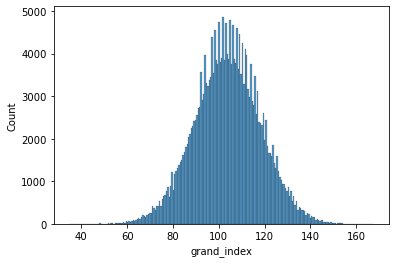

In [9]:
sns.histplot(data=df, x='grand_index')
print(df['grand_index'].describe())

We observed a normally distributed GI score with mean at around 100 and std at 14.<br>
To explore the possibility of differentiating the cognitive ability from demographic data,<br>
(reducing difficulty)<br>
we converted this natually prediction problem into a classification problem. <br>

Specifically, we treat subjects with top 25% GI score as high cognitive ability subjects,<br>
and subjects with with the bottom 25% GI score as low cognitive ability subjects.<br>
This procedure results in using half of the observants as training and testing dataset. 

In [10]:
# determining the number of observations in each class
num_of_class = round(df.shape[0] * 0.25)
print(f'For each class, we have {num_of_class} observations.')

# sort dataframe
df.sort_values('grand_index', inplace=True) # in ascending order 

df_low = df.head(num_of_class).copy()
df_high = df.tail(num_of_class).copy()

df_low['cog_ability'] = 'low'  
df_high['cog_ability'] = 'high' 

df_class = pd.concat([df_low, df_high],
                    axis=0,
                    ignore_index=True)

df_class.drop(['grand_index'], axis=1, inplace=True)
print(f'The dataframe for ML is in shape {df_class.shape}')

For each class, we have 62679 observations.
The dataframe for ML is in shape (125358, 7)


As the ML models we apply will operate on the preprocessed data, <br>
we save this dataframe for easy access. 

In [11]:
# save subsetted df for easier future access
df_class.to_csv('data/proj1_df.csv')

### 1.4 Data Cleaning II

In the previous section, we saved our subset of data as a file 'proj1_df.csv' for convinience of future use (so that users don't have to go through the initialy cleaning and subsetting procedures every time).

So the following procedures will start from the 'proj1_df.csv' file.


In [12]:
# read in subsetted data
df_data = pd.read_csv('./data/proj1_df.csv')

# drop indexing column
df_data.drop(['Unnamed: 0'], axis=1, inplace=True)

We save the data type regulation step until now to ensure that data types are correct after reading in subsetted data. 

In [13]:
df_data.dtypes

user_id              int64
age                float64
gender              object
education_level    float64
country             object
time_of_day          int64
cog_ability         object
dtype: object

Note that we have 2 tricky features in the dataset: *education_level* and *time_of_day*.<br>

- *education_level* represents the level of education attainment of each participant; it has 9 different levels (1: 'Some high school', 2: 'High school diploma/GED', 3: 'Some college', 4: 'College degree', 5: 'Professional degree', 6: 'Master's degree', 7: 'Ph.D.', 8: "Associate's degree", 99: 'Other'). Should we treat it as a categorical value or ordinal value? We note that these educational levels do not have a strictly ascending order; for example, 'Professional degree' such as JD and MD is assigned a lower level than 'Master's degree' in the dataset, whereas in reallife it is not always the case. Therefore, we treat it as a **categorical value** here.

- *time_of_day* represents the time (see detailed description above) the battery is completed. It is by nature a numeric value as 23 comes later in a day than 22 of the same day. However, it is also circular, meaning that 0 can also come after 23 (instead of being the earlist time of a day). Therefore, we treat it as a **categorical value** here. 

In [15]:
cat_columns = ['user_id', 'gender',
            'education_level', 'country',
            'time_of_day', 'cog_ability']

df_data[cat_columns] = df_data[cat_columns].astype('category')
df_data.dtypes

user_id            category
age                 float64
gender             category
education_level    category
country            category
time_of_day        category
cog_ability        category
dtype: object

### 1.5 Features Selection and Visualization

The previous steps have clarified the features(X) and target(y).<br>
In this section, we will get a sense of the distribution of features before training models.

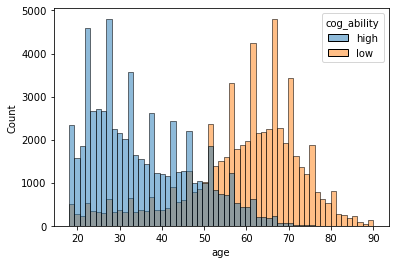

In [18]:
# distribution of age 
sns.histplot(df_data, x='age', hue='cog_ability')
plt.savefig('./figs/age_distribution.png', dpi=200)

We see a clear dissociation of age and cognitive ablity.<br>
This means age would be a good feature to classify cognitive ability.

Male Number : 54424
Female Number : 70934


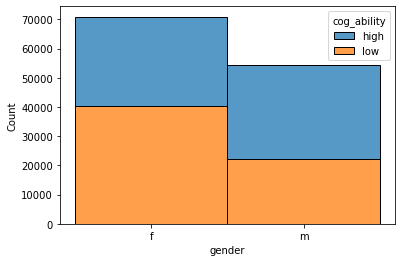

In [19]:
# gender 
sns.histplot(df_data, x='gender', hue='cog_ability', multiple='stack')
print(f"Male Number : {np.sum(df_data['gender']=='m')}")
print(f"Female Number : {np.sum(df_data['gender']=='f')}")

We see a higher propotion of male with high cognitive ability,<br>
which could also be a useful feature in our classification model. 

In [20]:
#df_data['education_level'] = df_data.education_level.replace([99], 9)

education_map = {1: 'Some high school',
                2: 'High school diploma/GED',
                3: 'Some college',
                4: 'College degree',
                5: 'Professional degree',
                6: "Master's degree",
                7: 'Ph.D.',
                8: "Associate's degree",
                99: 'Other'} 
df_data['education_level'] = df_data['education_level'].map(education_map)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

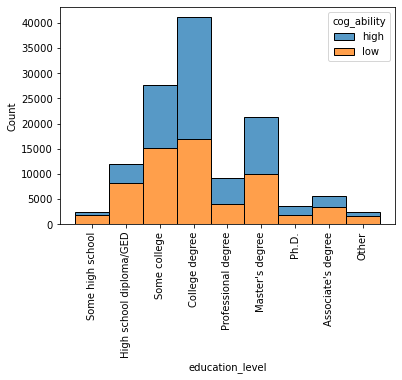

In [21]:
sns.histplot(df_data, x='education_level',hue='cog_ability', multiple='stack')
plt.xticks(rotation=90)

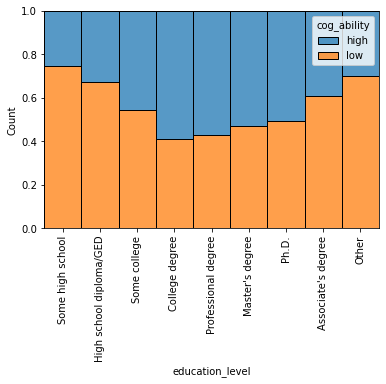

In [22]:
sns.histplot(df_data, x='education_level',hue='cog_ability', multiple='fill')
plt.xticks(rotation=90)
plt.savefig('figs/educational_level_fill.png', dpi=200)

We see different propotion of high VS low cognitive ability in different educational degrees.<br>
Therefore, educational level could be a feature to classify cognitive ability.

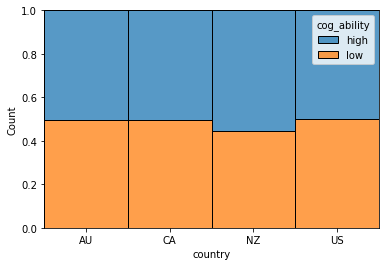

In [23]:
# country
sns.histplot(df_data, x='country',hue='cog_ability', multiple='fill')
plt.savefig('figs/country_fill.png', dpi=200)

Contrary to educational level, there is little variation of cognitive ability class among country.<br>
We would anticipate *country* as a none-predictive featrue for classification. 

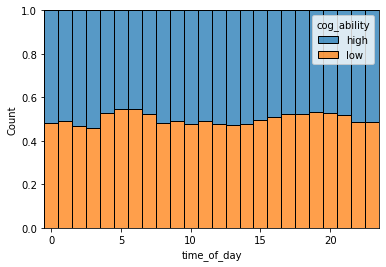

In [24]:
# time_of_day
sns.histplot(df_data, x='time_of_day', hue='cog_ability', multiple='fill')

Similarly, we see little differece in *time_of_day*,<br>
which would be a none-predictive feature in our classification task.<br>
As the purpose of our ML models is to classify participants into distinct cognitive ability groups,<br>
we consider the time one subject complete the whole battery as a **confounding factor**.<br>
Therefore, we will discard this feature in the following model training.

In [26]:
# drop unuseful column
df_data.drop(['time_of_day'], axis=1, inplace=True)

#### Feature Summary

After exploring all the available features, we would anticipate:<br>
- **Predictive Features** 
    - age
    - gender
    - educational level
- **None-predictive Features**
    - country

### 1.6 Check Multicollinearity

We employ **Variance Inflation Factor**(VIF) to detect multicollinearity.<br>
The greater the VIF is, the stronger the collinearity a feature has.<br>

Generally, a VIF above 4 indicates that multicollinearity might exist, and further investigation is required. <br>
When VIF is higher than 10, there is significant multicollinearity that needs to be corrected.

In [27]:
# to calculate VIF, we need to convert strings into categorical representation 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

cat_names = ['gender', 'education_level', 'country']
for col_name in cat_names:
    df_data[col_name] = le.fit_transform(df_data[col_name])
df_data.head(4)

,user_id,age,gender,education_level,country,cog_ability
0,69754110,79.0,0,1,3,low
1,104090018,51.0,1,3,3,low
2,87397599,33.0,0,4,3,low
3,62558139,76.0,1,1,3,low


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the feature set
variable_df = df_data.iloc[:, 1:-1]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = variable_df.columns
  
# calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(variable_df.values, i)
                          for i in range(len(variable_df.columns))]

vif_data

,feature,VIF
0,age,4.928579
1,gender,1.642837
2,education_level,2.463673
3,country,4.894018


Though we see VIFs of all features except *gender* exceed 4, they are nevertheless not significant.<br>
In our model, we will not drop any feature.

### 1.7 Feature Engineering

For the categorical features, we covert them into one-hot encoded fashion.

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# create X and y
X = df_data.drop(['user_id', 'cog_ability'], axis=1)
y = df_data['cog_ability']

# OHE
transformer = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                [1, 2, 3])], remainder="passthrough")
X = transformer.fit_transform(X)    

In [30]:
# the three categorical features are coded in the One Hot fashion 
cat_names = transformer.named_transformers_['OneHot'].get_feature_names_out()
print(cat_names)
X = np.asarray(X.todense()) # for the convenience of operatiing
print(X[0,:]) # with age passed to the end of the matrix 

['gender_0' 'gender_1' 'education_level_0' 'education_level_1'
 'education_level_2' 'education_level_3' 'education_level_4'
 'education_level_5' 'education_level_6' 'education_level_7'
 'education_level_8' 'country_0' 'country_1' 'country_2' 'country_3']
[ 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 79.]


label categories in y with numerical values

In [31]:
# convert y into category denoted by number 
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['high', 'low'], dtype=object)

check the shape of X and y

In [32]:
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (125358, 16)
y shape is (125358,)


## Part 2: Modeling

### 2.1 Standardization of Numeric Data; Get Training and Test Sets

We perform standardization on numerical data (age) for logistic regression

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[:,-1] = scaler.fit_transform(X[:,-1].reshape(-1,1)).flatten() 

Note that since random forest model is not sensitive to the variance of the dada, we will later transform age back to its original values (use scaler.inverse_transform()) for ease of interpretation.

We then split training and testing data

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Verify whether classes are splitted equally

In [37]:
from collections import Counter

print(f'Class distribution in test set: {Counter(y_test)}')

Class distribution in test set: Counter({1: 12570, 0: 12502})


As we have equal number of observants in both classes, and the class size is fairly close in test set,<br>
we can conclude that classes are equally splitted. 

### 2.2 Logistic Regression (LR) (Anmin Yang)

For LR, we are agnostic of the following parameters:<br>
- penalty type 
- regulation strength

We use grid search to determin the best combination of parameters.

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear', random_state=42)
parameters = [{'penalty':['l1','l2'],
            'C':[0.1, 1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator=clf,  
                           param_grid=parameters,
                           scoring='roc_auc', # we use auc as the evaluation of the model 
                           cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc')

In [40]:
print(f'Best AUC score: {grid_search.best_score_}')

print(f'Best parameter combination: {grid_search.best_params_}')

Best AUC score: 0.9049412985979437
Best parameter combination: {'C': 0.1, 'penalty': 'l1'}


We now train the logistic regression model with optimized parameters

In [41]:
clf = LogisticRegression(penalty='l1',
                        C=0.1,
                        solver='liblinear',
                        random_state=42).fit(X_train, y_train)

In [42]:
print(f'Traning Accuracy: {clf.score(X_train, y_train)}')

Traning Accuracy: 0.8324691382645634


### 2.3 Random Forest (RF) (Shan Gao)

Remember that we standardized age values for logistic regression.

For random forest, we convert age back to its original values for easier interpretaion of results.

In [45]:
X[:,-1] = scaler.inverse_transform(X[:,-1].reshape(-1,1)).flatten() 

In [46]:
# sanity check
X[:,-1]

array([79., 51., 33., ..., 27., 20., 25.])

Update the training and test sets after converting age back to its original values

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

For RF, we are agnostic of the following parameters:

- n_estimators 
- max_depth
- min_samples_split
- min_samples_leaf
- max_leaf_nodes

We use grid search to determin the best combination of parameters.

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
parameters = [{'n_estimators': np.arange(100, 500, 100),
            'max_depth': [None, 10, 9, 8, 7, 6, 5, 4, 3],
            'min_samples_split': np.linspace(0.05, 0.6, num=10),
            'min_samples_leaf': [1, 5, 10, 20, 50],
            'max_leaf_nodes': np.arange(2,20,3)}]

grid_search = GridSearchCV(estimator=rf_clf,  
                           param_grid=parameters,
                           scoring='roc_auc', # we use auc as the evaluation of the model 
                           cv=10)
grid_search.fit(X_train, y_train)

In [ ]:
print(f'Best AUC score: {grid_search.best_score_}')

print(f'Best parameter combination: {grid_search.best_params_}')

# save variable for easier future use
%store grid_search
# %store -r grid_search

We then train the RF classifier model with optimized parameters

Let's take a look at what a tree in our RF looks like

In [ ]:
from sklearn import tree
import graphviz 

When does our RF classifer fail?

### 2.4 Model Comparison

### 2.5 Generalizability

## Part 3 Conclusion

## 